In [5]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import xgboost as xgb

pd.set_option('display.max_columns', 100)

In [16]:
RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 500 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier

#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation

RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

IS_LOCAL = True

import os

In [22]:
lukup = {'defaultCredit':'default.payment.next.month', 'bank':'y'}
name = 'bank'
label = lukup[name]
train_df = pd.read_csv('/home/vineeth/Documents/GitWorkSpace/PytorchRecipes/SimpleMLP/Dataset/{}/fold0/train/data.csv'.format(name))
valid_df = pd.read_csv('/home/vineeth/Documents/GitWorkSpace/PytorchRecipes/SimpleMLP/Dataset/{}/fold0/valid/data.csv'.format(name))
test_df = pd.read_csv('/home/vineeth/Documents/GitWorkSpace/PytorchRecipes/SimpleMLP/Dataset/{}/fold0/test/data.csv'.format(name))
train_label, valid_label, test_label = train_df[label], valid_df[label], test_df[label]
train_df, valid_df, test_df = train_df.drop(label, axis=1), valid_df.drop(label, axis=1), test_df.drop(label, axis=1)
numerical_feat = pd.read_csv('/home/vineeth/Documents/GitWorkSpace/PytorchRecipes/SimpleMLP/Dataset/{}/numerical_clms.csv'.format(name)).columns
train_df = train_df[numerical_feat]
valid_df = valid_df[numerical_feat]
test_df = test_df[numerical_feat]
predictors = train_df.columns
train_df.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,-1.249775,-0.074380,1.961172,0.195414,-0.349494,0.839061,0.591424,-0.474791,0.773575,0.845170
1,-1.057857,-0.533350,0.156105,0.195414,-0.349494,0.839061,-0.227465,0.951267,0.773575,0.845170
2,-0.386145,-0.398359,-0.204909,0.195414,-0.349494,0.839061,0.591424,-0.474791,0.772422,0.845170
3,-0.098268,-0.386788,-0.204909,0.195414,-0.349494,-1.197935,-1.179380,-1.231034,-1.357965,-0.940281
4,-0.002309,-0.085951,1.600159,0.195414,-0.349494,0.839061,-0.227465,0.951267,0.775305,0.845170


In [23]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df.values, train_label.values.flatten(), feature_names=predictors)
dvalid = xgb.DMatrix(valid_df.values, valid_label.values.flatten(), feature_names=predictors)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = ['auc','aucpr']
params['random_state'] = RANDOM_STATE

In [24]:

model = xgb.train(params, 
                dtrain, 
                
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

[22:06:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1667849527992/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-auc:0.84314	train-aucpr:0.49701	valid-auc:0.83174	valid-aucpr:0.46186


/home/vineeth/anaconda3/envs/pytorch_01_2023/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[50]	train-auc:0.93063	train-aucpr:0.61817	valid-auc:0.91758	valid-aucpr:0.55794
[100]	train-auc:0.93703	train-aucpr:0.63331	valid-auc:0.92156	valid-aucpr:0.57714
[150]	train-auc:0.94008	train-aucpr:0.64396	valid-auc:0.92370	valid-aucpr:0.58634
[200]	train-auc:0.94222	train-aucpr:0.65180	valid-auc:0.92643	valid-aucpr:0.59350
[250]	train-auc:0.94364	train-aucpr:0.65778	valid-auc:0.92796	valid-aucpr:0.59714
[300]	train-auc:0.94507	train-aucpr:0.66298	valid-auc:0.92928	valid-aucpr:0.60307
[350]	train-auc:0.94639	train-aucpr:0.66673	valid-auc:0.93028	valid-aucpr:0.60493
[400]	train-auc:0.94781	train-aucpr:0.67060	valid-auc:0.93134	valid-aucpr:0.60529
[417]	train-auc:0.94808	train-aucpr:0.67267	valid-auc:0.93149	valid-aucpr:0.60623


In [25]:
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score, roc_auc_score
dtest = xgb.DMatrix(test_df.values, feature_names=predictors)
y_pred = model.predict(dtest)
print(classification_report(test_label.values.flatten(), np.rint(y_pred)))

print("ROC-AUC:{}".format(roc_auc_score(test_label.values.flatten(), y_pred)))
print("PrecisionRecall-AUC:{}".format(average_precision_score(test_label.values.flatten(), y_pred)))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      7306
           1       0.65      0.51      0.57       932

    accuracy                           0.91      8238
   macro avg       0.80      0.74      0.76      8238
weighted avg       0.91      0.91      0.91      8238

ROC-AUC:0.9446831577079924
PrecisionRecall-AUC:0.6459461412374515


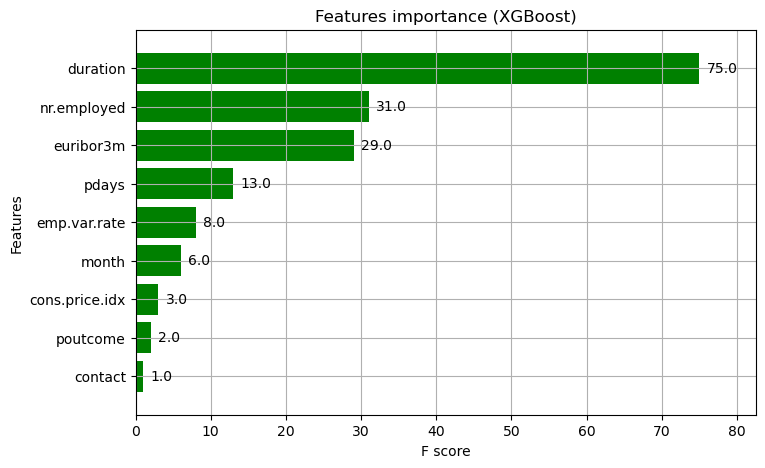

In [21]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green") 
plt.show()